#### imports


In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt

from ode_filters.priors.GMP_priors import taylor_mode_initialization, PrecondIWP
from ode_filters.measurement.measurement_models import ODEInformation
from ode_filters.filters.ODE_filter_loop import (
    ekf1_sqr_loop_preconditioned,
    rts_sqr_smoother_loop_preconditioned,
)

### Example 1: Logistic ODE


In [2]:
def vf(x, *, t):
    return x * (1 - x)


x0 = np.array([0.01])
tspan = [0, 10]
d = x0.shape[0]

In [5]:
q = 2
D = d * (q + 1)
xi = 0.5 * np.eye(d)
prior = PrecondIWP(q, d, Xi=xi)
mu_0, Sigma_0_sqr = taylor_mode_initialization(vf, x0, q)


# domain discretization (unifrom grid)
N = 21
ts = np.linspace(tspan[0], tspan[1], N + 1)

measure = ODEInformation(vf, prior.E0, prior.E1)

In [6]:
# apply ODE filter
(
    m_seq,
    P_seq_sqr,
    m_seq_bar,
    P_seq_sqr_bar,
    m_pred_seq_bar,
    P_pred_seq_sqr_bar,
    G_back_seq_bar,
    d_back_seq_bar,
    P_back_seq_sqr_bar,
    mz_seq,
    Pz_seq_sqr,
    T_h,
) = ekf1_sqr_loop_preconditioned(mu_0, Sigma_0_sqr, prior, measure, tspan, N)

# apply ODE smoother
m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop_preconditioned(
    m_seq[-1],
    P_seq_sqr[-1],
    m_seq_bar[-1],
    P_seq_sqr_bar[-1],
    G_back_seq_bar,
    d_back_seq_bar,
    P_back_seq_sqr_bar,
    N,
    T_h,
)

In [7]:
m_seq = np.array(m_seq)
P_seq_sqr = np.array(P_seq_sqr)

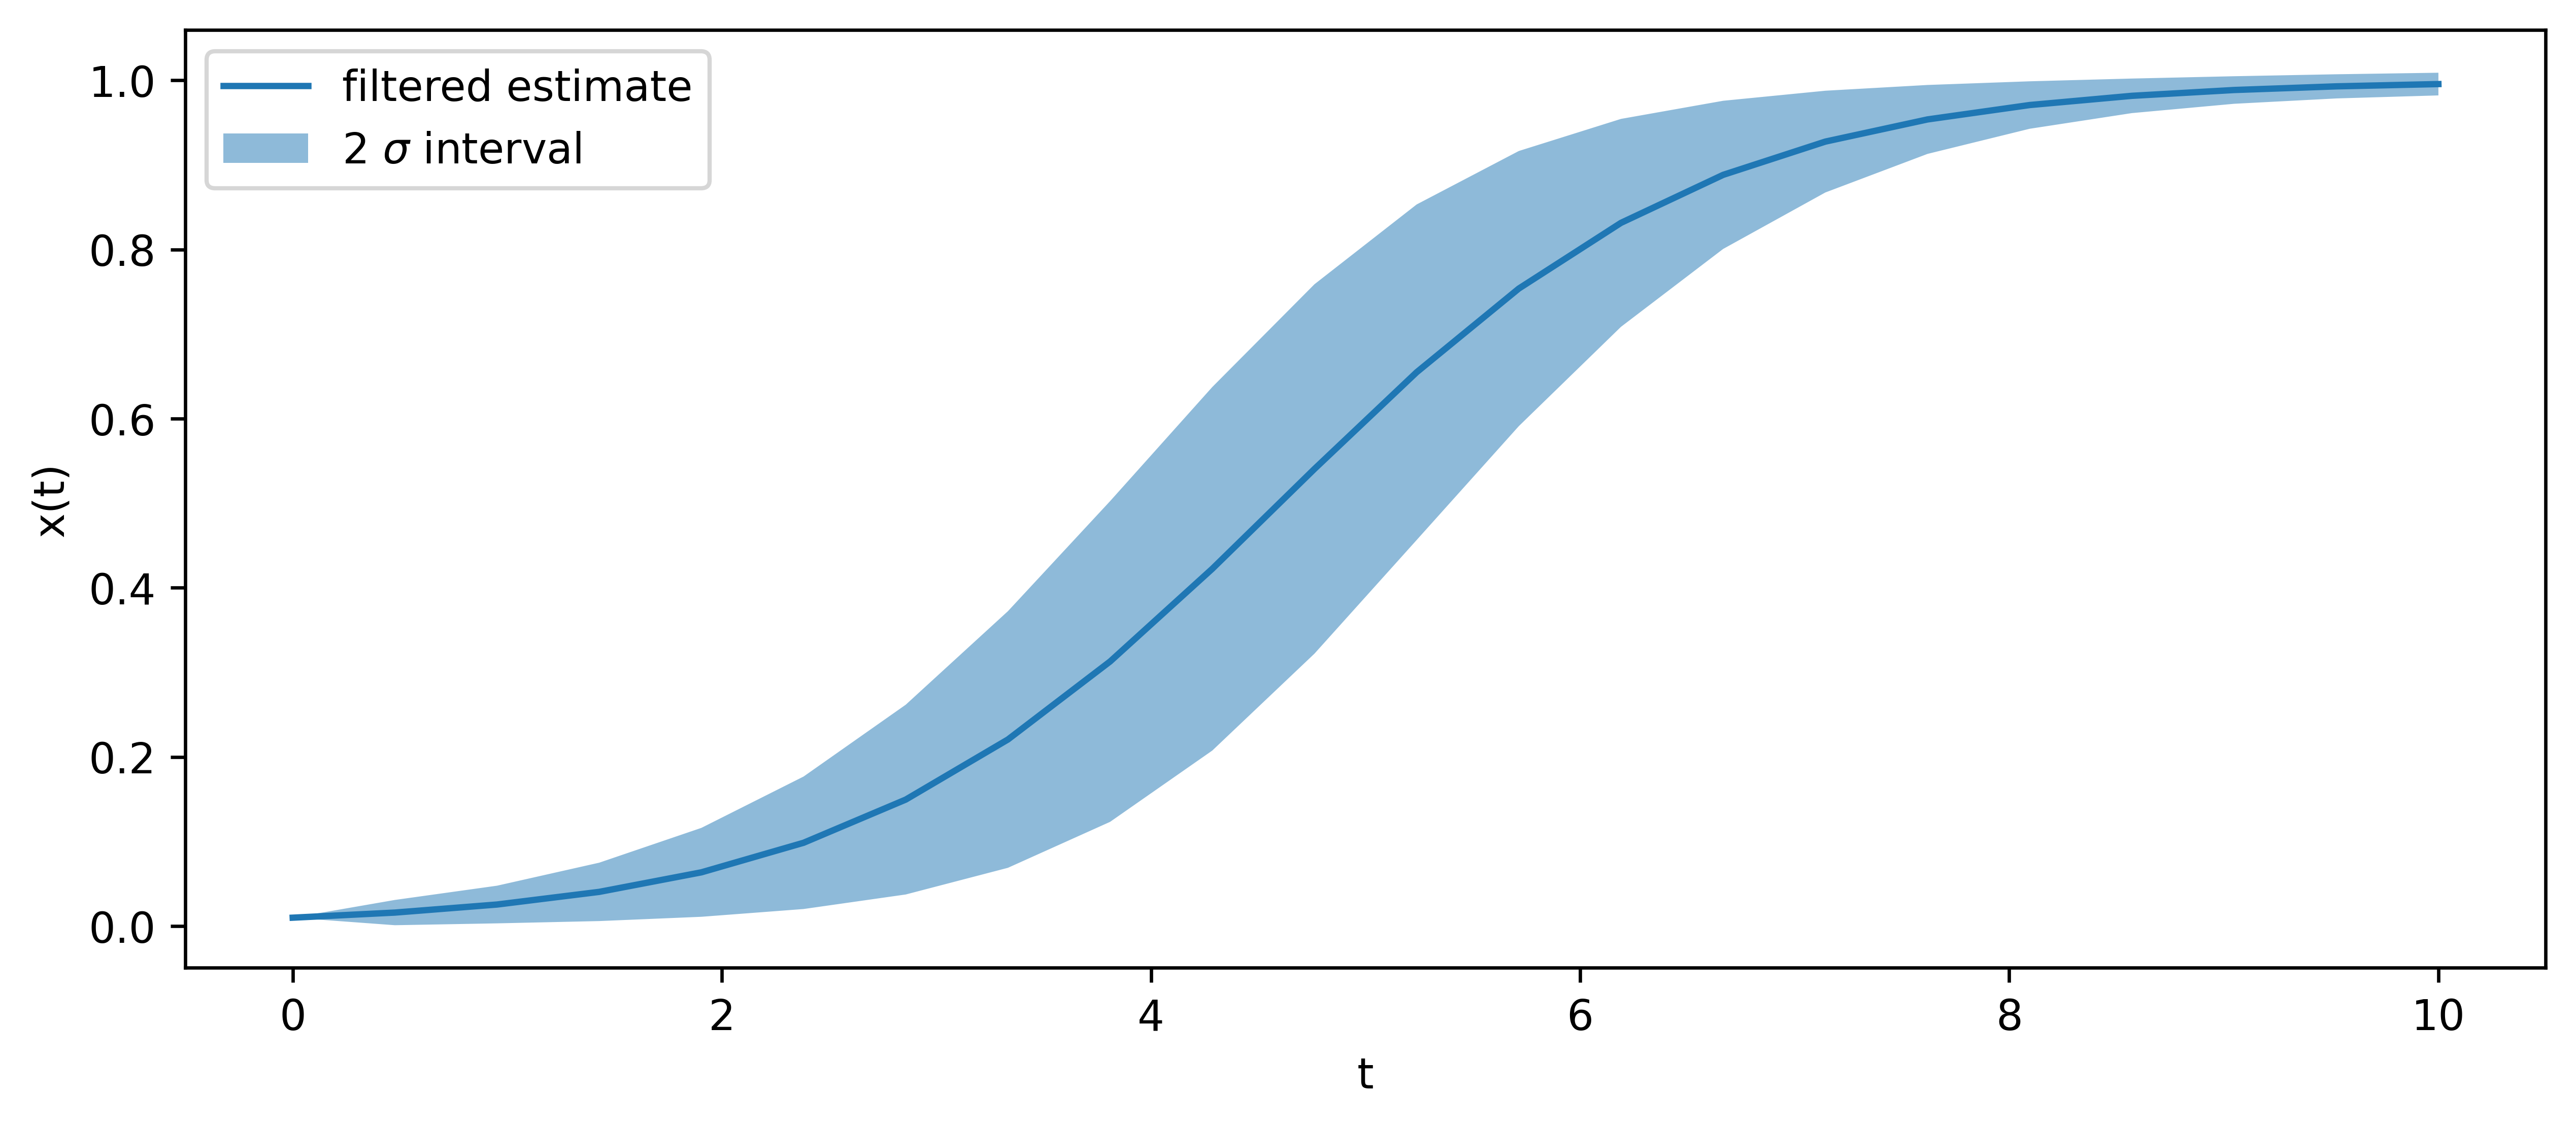

In [8]:
plt.figure(figsize=(10, 4), dpi=600)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.plot(ts, m_seq[:, 0], label="filtered estimate")
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(P_seq[:, 0, 0])
plt.fill_between(
    ts,
    m_seq[:, 0] - margin,
    m_seq[:, 0] + margin,
    alpha=0.5,
    label=r"2 $\sigma$ interval",
)
plt.legend()
plt.show()

### Example 2: Lotka Volterra

$$\begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} \alpha x - \beta x y \\ -\gamma y + \delta x y \end{bmatrix}, \quad \begin{bmatrix}\alpha \\ \beta \\ \gamma \\ \delta  \end{bmatrix} = \begin{bmatrix} 2/3 \\ 4/3 \\ 1 \\1 \end{bmatrix}, \quad \begin{bmatrix}x_0 \\ y_0 \end{bmatrix} = \begin{bmatrix}1, 1\end{bmatrix}, \quad t \in [0, 30]$$


In [9]:
def vf(x, *, t):
    return np.array([2.0 * x[0] / 3.0 - 4.0 * x[0] * x[1] / 3.0, x[0] * x[1] - x[1]])


x0 = np.array([1.0, 1.0])
tspan = [0.0, 30.0]
d = x0.shape[0]

In [10]:
# prior
q = 2
D = d * (q + 1)
xi = 1.0 * np.eye(d)
prior = PrecondIWP(q, d, Xi=xi)
mu_0, Sigma_0_sqr = taylor_mode_initialization(vf, x0, q)

# domain discretization (unifrom grid)
N = 60
ts = np.linspace(tspan[0], tspan[1], N + 1)

measure = ODEInformation(vf, prior.E0, prior.E1)

In [11]:
# apply ODE filter
(
    m_seq,
    P_seq_sqr,
    m_seq_bar,
    P_seq_sqr_bar,
    m_pred_seq_bar,
    P_pred_seq_sqr_bar,
    G_back_seq_bar,
    d_back_seq_bar,
    P_back_seq_sqr_bar,
    mz_seq,
    Pz_seq_sqr,
    T_h,
) = ekf1_sqr_loop_preconditioned(mu_0, Sigma_0_sqr, prior, measure, tspan, N)

# apply ODE smoother
m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop_preconditioned(
    m_seq[-1],
    P_seq_sqr[-1],
    m_seq_bar[-1],
    P_seq_sqr_bar[-1],
    G_back_seq_bar,
    d_back_seq_bar,
    P_back_seq_sqr_bar,
    N,
    T_h,
)

In [12]:
m_seq = np.array(m_seq)
P_seq_sqr = np.array(P_seq_sqr)

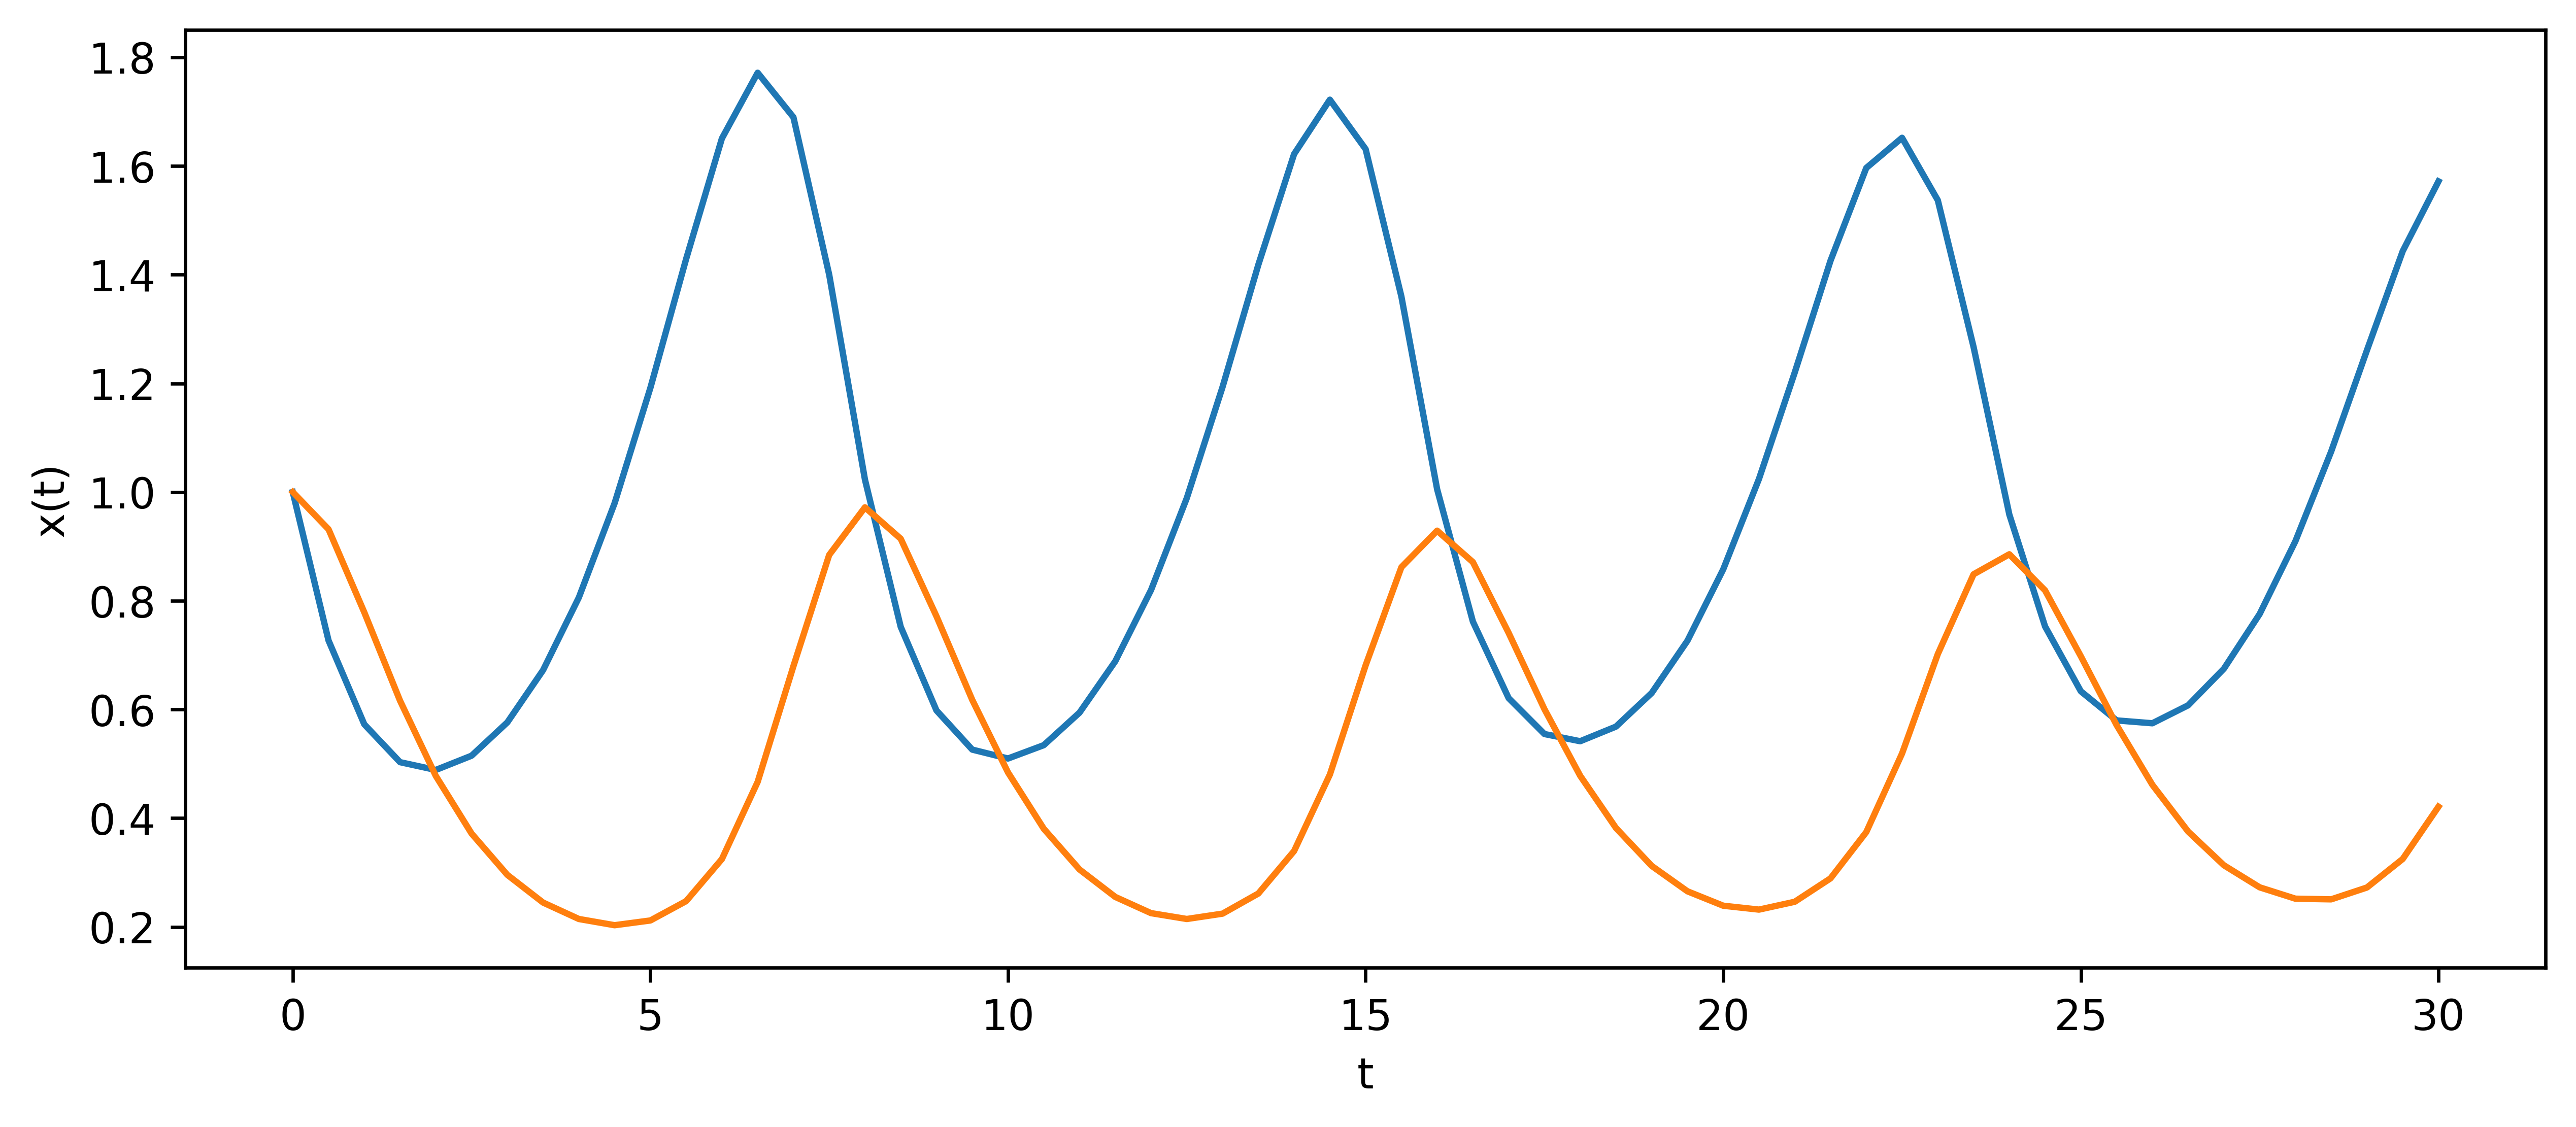

In [13]:
plt.figure(figsize=(10, 4), dpi=600)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.plot(ts, m_seq[:, :d])
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(np.diagonal(P_seq[:, :d, :d], axis1=1, axis2=2))
plt.show()

### Example 3: SIR model

$$\begin{bmatrix} S \\ I \\ R \end{bmatrix} = \begin{bmatrix} -\beta IS \\ \beta IS - \gamma I \\ \gamma I  \end{bmatrix}, \quad \begin{bmatrix} \beta \\ \gamma \end{bmatrix} = \begin{bmatrix} 0.5 \\ 0.1  \end{bmatrix}, \quad \begin{bmatrix} S_0 \\ I_0 \\ R_0 \end{bmatrix} = \begin{bmatrix} 0.99 \\ 0.01 \\ 0 \end{bmatrix}, \quad t \in [0,100]$$


In [14]:
def vf(x, *, t, beta=0.5, gamma=0.1):
    return np.array(
        [-1 * beta * x[0] * x[1], beta * x[0] * x[1] - gamma * x[1], gamma * x[1]]
    )


x0 = np.array([0.99, 0.01, 0.0])
tspan = [0.0, 100.0]
d = x0.shape[0]

In [15]:
# prior
q = 2
D = d * (q + 1)
xi = 1.0 * np.eye(d)
prior = PrecondIWP(q, d, Xi=xi)
mu_0, Sigma_0_sqr = taylor_mode_initialization(vf, x0, q)


# domain discretization (unifrom grid)
N = 100
ts = np.linspace(tspan[0], tspan[1], N + 1)

measure = ODEInformation(vf, prior.E0, prior.E1)

In [16]:
# apply ODE filter
(
    m_seq,
    P_seq_sqr,
    m_seq_bar,
    P_seq_sqr_bar,
    m_pred_seq_bar,
    P_pred_seq_sqr_bar,
    G_back_seq_bar,
    d_back_seq_bar,
    P_back_seq_sqr_bar,
    mz_seq,
    Pz_seq_sqr,
    T_h,
) = ekf1_sqr_loop_preconditioned(mu_0, Sigma_0_sqr, prior, measure, tspan, N)

# apply ODE smoother
m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop_preconditioned(
    m_seq[-1],
    P_seq_sqr[-1],
    m_seq_bar[-1],
    P_seq_sqr_bar[-1],
    G_back_seq_bar,
    d_back_seq_bar,
    P_back_seq_sqr_bar,
    N,
    T_h,
)

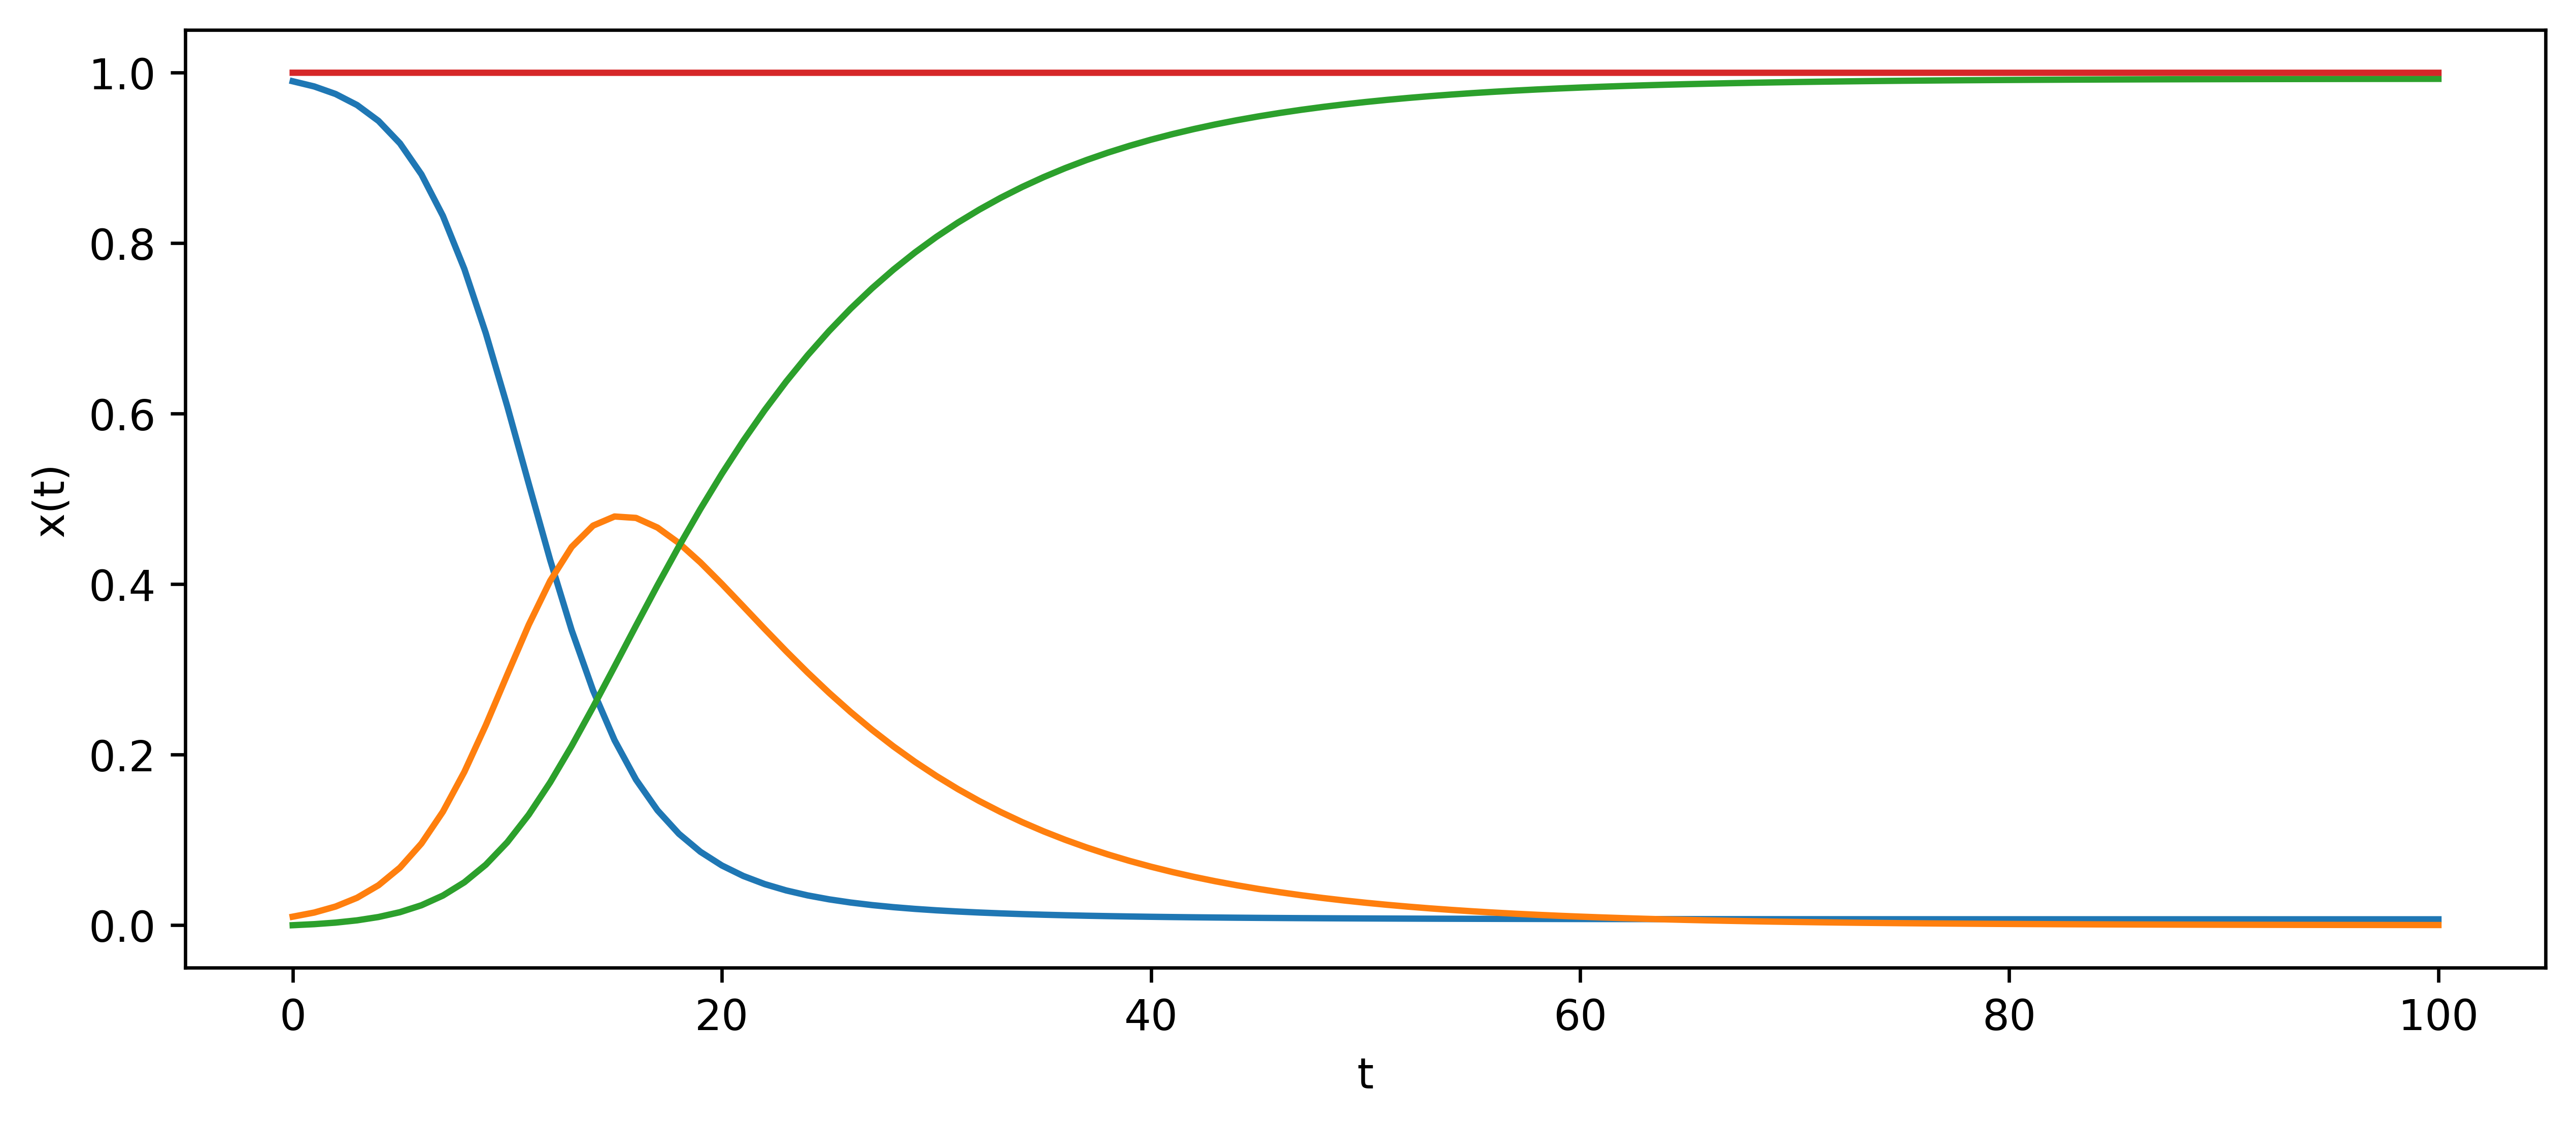

In [17]:
m_seq = np.array(m_seq)
plt.figure(figsize=(10, 4), dpi=600)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.plot(ts, m_seq[:, :3])
plt.plot(ts, m_seq[:, :3].sum(axis=1))
plt.show()